## STR Tree Spatial Index
The data used are shapefiles of Virginia Road Centerlines (RCL) and Virginia Railroad; both from [Virginia Geographic Information Network](https://vgin.vdem.virginia.gov/). The railroad data had no modifications leaving the original 9,113 features in tact. The road shapefile was pre-filtered to only include roads with 70+ mph speed limits which kept 3,793 features of 649,584 (reduction of 99.4%) due to extreme calculation times when not using a spatial index.

The library used for spatial indexing is the shapely library which is also the underlying library used by geopandas (a geospatially enabled version of pandas). The spatial index included with shapely is the STR Tree spatial index which is described in the documentation as: 
>A query-only R-tree spatial index created using the Sort-Tile-Recursive (STR) [1] algorithm.
>The tree indexes the bounding boxes of each geometry. The tree is constructed directly at initialization and nodes cannot be added or removed after it has been created.
>All operations return indices of the input geometries. These indices can be used to index into anything associated with the input geometries, including the input geometries themselves, or custom items stored in another object of the same length as the geometries.

STRtree is using R tree for indexing. What gives this an advantage of a standard R Tree is how efficiently it packages or builds the R Tree spatial index.

The other packages included in this notebook are for manipulating the data more efficiently (shapefile, numpy, pandas, geopandas), plotting on maps (matplotlib), and transforming the data (pyproj).

### Import libraries and prepare the data

In [1]:
from shapely import intersection
from shapely.ops import transform
from shapely.geometry import MultiPoint
import pyproj, os, shapefile, shapely
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

root_src = r'GLGD4003 Spatial Data Structures\Module2\Homework'
railroads = os.path.join(root_src,r'VGIN_RAIL\Railroad.shp') # 9113 features
roads = os.path.join(root_src,r'VirginiaRoadCenterline\VirginiaRoad_70plus.shp') # 3793 features

wgs84 = pyproj.CRS('EPSG:4326')
Lambert_Conformal_Conic_Virginia = pyproj.CRS('EPSG:3968')
project = pyproj.Transformer.from_crs(Lambert_Conformal_Conic_Virginia, wgs84, always_xy=True).transform

C:\Users\Doug PC\AppData\Local\Temp\ipykernel_16836\223877227.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


### Helper functions

shapefileToShapely - opens the shapefile which is known to be polylines, turns it into shapely LineString datatype, transforms to appropriate projection, and creates a numpy array

queryIndex - uses built strtree from shapely library and runs the intersect query which initially returns the indices of the lines that intersect from the two datasets (road and rail). A feature is gathered from each dataset based on the indexed pairs returned from before. Each pair of features has another shapely function run to find the intersection point geometry and returns as a list

findIntersectionPoints - iterates through both the road and rail features and tests to see if they intersect. If they do, then the intersection point geometry is calculated and returned as a list

In [2]:
def shapefileToShapely(filename):
    shp = shapefile.Reader(filename)
    geoms = [shapely.geometry.LineString(rec.shape.points) for rec in shp.shapeRecords()]
    geoms_shapely = np.array([transform(project, L) for L in geoms])
    return geoms_shapely

def queryIndex(geoms,strtree):
    indices = strtree.query(geoms,predicate='intersects')
    result_pairs = np.array([geoms.take(indices[0]),strtree.geometries.take(indices[1])]).T.tolist()
    intersect_pts = [intersection(a,b) for a,b in result_pairs]
    return intersect_pts

def findIntersectPoints(line1,line2):
    pnts = list()
    for i in line1:
        for j in line2:
            if i.intersects(j):
                pnts.append(intersection(i,j))
    return pnts

### Getting the data ready

In [3]:
print('Import Railroad Shapefile')
%timeit rail_geoms_shapely = shapefileToShapely(railroads)
rail_geoms_shapely = shapefileToShapely(railroads)
print('Import Road Shapefile')
%timeit road_geoms_shapely = shapefileToShapely(roads)
road_geoms_shapely = shapefileToShapely(roads)

Import Railroad Shapefile
1.94 s ± 56.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Import Road Shapefile
928 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Building the spatial index

In [4]:
print('Build Index')
%timeit roads_strtree = shapely.STRtree(road_geoms_shapely)
roads_strtree = shapely.STRtree(road_geoms_shapely)

Build Index
494 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Querying against the index

In [5]:
print('Query index')
%timeit intersect_pts = queryIndex(rail_geoms_shapely,roads_strtree)
intersect_pts = queryIndex(rail_geoms_shapely,roads_strtree)

Query index
14.9 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Querying against the raw geometry

In [7]:
%timeit intersect_pairs = findIntersectPoints(road_geoms_shapely,rail_geoms_shapely)

E:\Miniconda\envs\spatialidx\Lib\site-packages\shapely\predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


8min 49s ± 2.88 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


| Query execution time | Range query (average of 7 times) |
|----------------------|----------------------------------|
|No index | 8min 49s ± 2.88 s per loop |
|STR tree | 14.9 ms ± 187 µs per loop |

### Map of output

<AxesSubplot: >

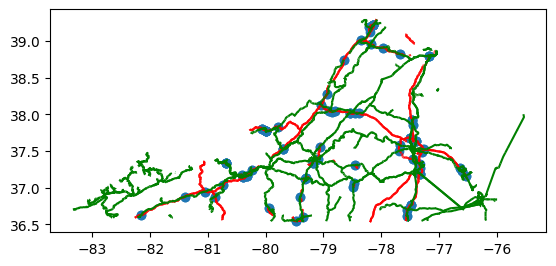

In [6]:
cmap_red = ListedColormap(['red'], name='allred')
cmap_green = ListedColormap(['green'], name='allred')

gdf1 = gpd.GeoDataFrame(geometry=road_geoms_shapely,crs='epsg:4326')
gdf2 = gpd.GeoDataFrame(geometry=rail_geoms_shapely,crs='epsg:4326')
gdf3 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(MultiPoint(np.array(intersect_pts))),crs='epsg:4326')
ax = gdf1.plot(cmap=cmap_red)
gdf2.plot(ax=ax, cmap=cmap_green)
gdf3.plot(ax=ax)